# Lotka-volterra

Example taken from: Julia DiffEqParamEstim module (https://docs.sciml.ai/DiffEqParamEstim/stable/tutorials/generalized_likelihood/)

```
f1 = function (du, u, p, t)
    du[1] = p[1] * u[1] - p[2] * u[1] * u[2]
    du[2] = -3.0 * u[2] + u[1] * u[2]
end
p = [1.5, 1.0]
u0 = [1.0; 1.0]
tspan = (0.0, 10.0)
```


### Original model

$$ \begin{cases} \frac{dx}{dt} = \alpha x - \beta x y \\
                 \frac{dy}{dt} = -3 y + xy \end{cases} $$

True parameter values: $\alpha = 1.5, \beta = 1$

Initial conditions: $x(0) = 1, y(0) = 1$

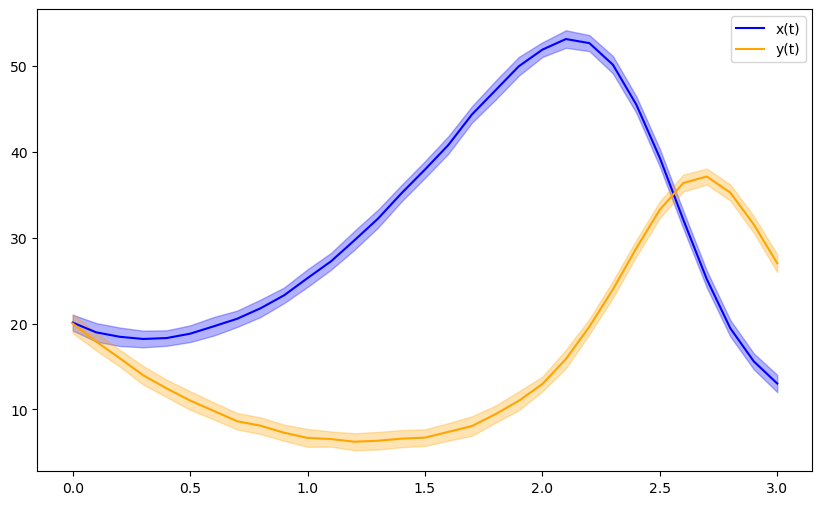

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def lotka_volterra(x0, y0, T, alpha, beta, dt):
    
    t = [0.]
    x = [x0]
    y = [y0]


    while(t[-1] < T):
        xt = x[-1] + dt * (alpha * x[-1] - beta * x[-1] * y[-1])
        yt = y[-1] + dt * (-3*y[-1] + beta * x[-1] * y[-1])
        x.append(xt)
        y.append(yt)
        t.append(t[-1] + dt)

    return t, x, y

def lotka_volterra_noisy(x0, y0, T, alpha, beta, dt, n_rep, sigma = 0.1):

    len_T = int(T/dt) + 1

    x_samples = np.zeros((n_rep, len_T))
    y_samples = np.zeros((n_rep, len_T))

    for i in range(n_rep):
        t, x, y = lotka_volterra(x0, y0, T, alpha, beta, dt)
        x = np.array(x) + np.random.normal(0, sigma, len(x))
        y = np.array(y) + np.random.normal(0, sigma, len(y))
        x_samples[i] = x
        y_samples[i] = y

    return t, x_samples, y_samples


t_samples, x_samples, y_samples = lotka_volterra_noisy(20, 20, T=3, alpha=1.5, beta=0.1, dt=0.1, n_rep=100, sigma=1)

mean_x = np.mean(x_samples, axis=0)
std_x = np.std(x_samples, axis=0)

mean_y = np.mean(y_samples, axis=0)
std_y = np.std(y_samples, axis=0)

# Plotting x(t) with uncertainty
plt.figure(figsize=(10, 6))
plt.plot(t_samples, mean_x, label='x(t)', color='blue')
plt.fill_between(t_samples, mean_x - std_x, mean_x + std_x, color='blue', alpha=0.3)

# Plotting y(t) with uncertainty
plt.plot(t_samples, mean_y, label='y(t)', color='orange')
plt.fill_between(t_samples, mean_y - std_y, mean_y + std_y, color='orange', alpha=0.3)

plt.legend()

In [2]:
x_samples[:10].shape
y_samples[:10].shape

(10, 31)

### Parameter estimation in SOGA 

In [3]:
from sogaPreprocessor import *
from producecfg import *
from libSOGAsmoother import *
from time import time

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

In [4]:


def extract_mean_and_std(output_dist):

    x_soga = [20.]
    y_soga = [20.]
    x_soga_std = [0.]
    y_soga_std = [0.]

    for i in range(29):
        x_idx = output_dist.var_list.index('x[{}]'.format(i))
        y_idx = output_dist.var_list.index('y[{}]'.format(i))
        x_soga.append(output_dist.gm.mean()[x_idx].item())
        y_soga.append(output_dist.gm.mean()[y_idx].item())
        x_soga_std.append(np.sqrt(output_dist.gm.cov()[x_idx][x_idx].item()))
        y_soga_std.append(np.sqrt(output_dist.gm.cov()[y_idx][y_idx].item()))

    return x_soga, y_soga, x_soga_std, y_soga_std

def plot_mean_and_std(x, y, x_std, y_std, label_x, label_y):
    
    t = np.linspace(0, 3, len(x))

    plt.plot(t, x, label=label_x, color='blue')
    plt.fill_between(t, np.array(x) - np.array(x_std), np.array(x) + np.array(x_std), color='blue', alpha=0.3)
    plt.plot(t, y, label=label_y, color='orange')
    plt.fill_between(t, np.array(y) - np.array(y_std), np.array(y) + np.array(y_std), color='orange', alpha=0.3)


In [5]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/gm_diff_eq.soga')
cfg = produce_cfg(compiledFile)

pars = {'mu1':1., 's1':1.,'mu2':0., 's2':1., 'w1':0.8, 'w2':0.2 }  # starting from wrong parameters

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

Entering EntryNode<>
1  components


Entering StateNode<state0,None,xcurr=20.>
1  components


Entering StateNode<state1,None,ycurr=20.>
1  components


Entering LoopNode<loop0>
1  components


Entering StateNode<state2,True,x[i]=xcurr+0.1*gm([_w1,_w2],[_mu1,_mu2],[_s1,_s2])>
1  components


Entering StateNode<state3,None,y[i]=ycurr+0.1*gm([_w1,_w2],[_mu1,_mu2],[_s1,_s2])>
2  components


Entering StateNode<state4,None,xcurr=x[i]>
4  components


Entering StateNode<state5,None,ycurr=y[i]>
4  components


Entering LoopNode<loop0>
4  components


Entering StateNode<state2,True,x[i]=xcurr+0.1*gm([_w1,_w2],[_mu1,_mu2],[_s1,_s2])>
4  components


Entering StateNode<state3,None,y[i]=ycurr+0.1*gm([_w1,_w2],[_mu1,_mu2],[_s1,_s2])>
8  components


Entering StateNode<state4,None,xcurr=x[i]>
16  components


Entering StateNode<state5,None,ycurr=y[i]>
16  components


Entering LoopNode<loop0>
16  components


Entering StateNode<state2,True,x[i]=xcurr+0.1*gm([_w1,_w2],[_mu1,_mu2],[_s1,_s2])>
16  co

KeyboardInterrupt: 

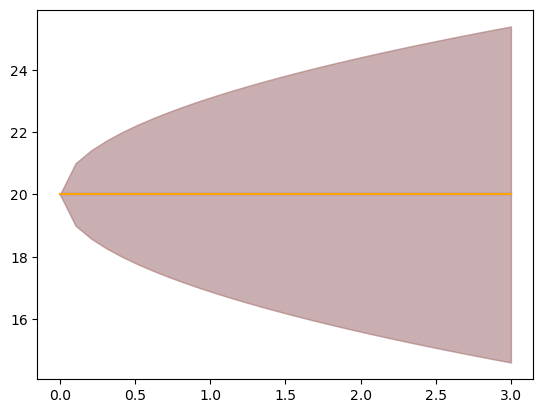

In [8]:
x_soga, y_soga, x_soga_std, y_soga_std = extract_mean_and_std(output_dist)
plot_mean_and_std(x_soga, y_soga, x_soga_std, y_soga_std, 'x(t) initial', 'y(t) initial')


In [9]:
# Preparing trajectories data

n_traj = 50

x_traj_idx = []
y_traj_idx = []

for i in range(1,30):
    x_traj_idx.append(output_dist.var_list.index('x[{}]'.format(i)))
    y_traj_idx.append(output_dist.var_list.index('y[{}]'.format(i)))

x_traj = torch.tensor(x_samples[:n_traj, :29])
y_traj = torch.tensor(y_samples[:n_traj, :29])

# loss

def neg_log_likelihood(x_traj, y_traj, dist):
    log_likelihood = torch.log(dist.gm.marg_pdf(x_traj, x_traj_idx)) + torch.log(dist.gm.marg_pdf(y_traj, y_traj_idx))
    return - torch.sum(log_likelihood)

neg_log_likelihood(x_traj, y_traj, output_dist)

tensor(15686.5488, grad_fn=<NegBackward0>)

In [15]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)
pars = {'mu1':0., 's1':1.,'mu2':0., 's2':1. }

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.1)

total_start = time()

for i in range(1000):

    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)

    loss = neg_log_likelihood(x_traj, y_traj, current_dist)

    # Backpropagate
    loss.backward()
    
    optimizer.step()

    
    # Print progress
    if i % 100 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))


mu1: -0.09999999995061905 s1: 1.0999999999999346 mu2: 0.09999999999868213 s2: 1.0999999999998715  loss: 15686.560344358582
mu1: -0.013200719611308137 s1: 3.198265404252123 mu2: 0.5042318218478673 s2: 2.4823809802464782  loss: 7240.156935127529
mu1: -0.01350303921104515 s1: 3.3630148203470913 mu2: 0.505849392579463 s2: 2.4701319989393595  loss: 7234.547169549396
mu1: -0.013500499823570109 s1: 3.3944801673630125 mu2: 0.5058652134210632 s2: 2.4700469216603005  loss: 7234.385286262128
mu1: -0.013500479602763913 s1: 3.397906560966292 mu2: 0.5058653229035124 s2: 2.470046513487922  loss: 7234.38356176572
mu1: -0.013500479474130554 s1: 3.398089124086149 mu2: 0.5058653223217533 s2: 2.4700465147083466  loss: 7234.3835571029285
mu1: -0.013500479474696032 s1: 3.39809289388682 mu2: 0.5058653223200322 s2: 2.4700465147096016  loss: 7234.383557100964
mu1: -0.013500479474698538 s1: 3.398092904298013 mu2: 0.505865322320018 s2: 2.470046514709603  loss: 7234.383557100966
mu1: -0.013500479474702941 s1: 3.3

In [16]:
params_dict

{'mu1': tensor(-0.0135, requires_grad=True),
 's1': tensor(3.3981, requires_grad=True),
 'mu2': tensor(0.5059, requires_grad=True),
 's2': tensor(2.4700, requires_grad=True)}

In [17]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/gm_diff_eq.soga')
cfg = produce_cfg(compiledFile)
output_dist = start_SOGA_smooth(cfg, params_dict)

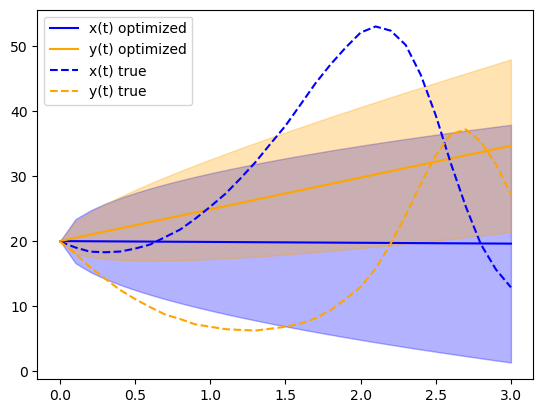

In [18]:
x_opt, y_opt, x_opt_std, y_opt_std = extract_mean_and_std(output_dist)

plot_mean_and_std(x_opt, y_opt, x_opt_std, y_opt_std, 'x(t) optimized', 'y(t) optimized')
#plot_mean_and_std(x_soga, y_soga, x_soga_std, y_soga_std, 'x(t) initial', 'y(t) initial')
plt.plot(t_samples, mean_x, label='x(t) true', color='blue', linestyle='dashed')
plt.plot(t_samples, mean_y, label='y(t) true', color='orange', linestyle='dashed')

plt.legend()

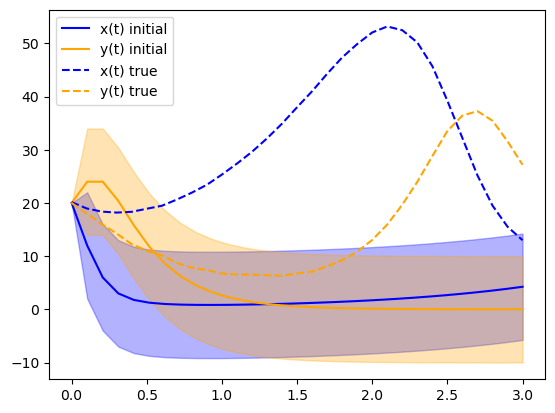

In [12]:
#plot_mean_and_std(x_opt, y_opt, x_opt_std, y_opt_std, 'x(t) optimized', 'y(t) optimized')
plot_mean_and_std(x_soga, y_soga, x_soga_std, y_soga_std, 'x(t) initial', 'y(t) initial')
plt.plot(t_samples, mean_x, label='x(t) true', color='blue', linestyle='dashed')
plt.plot(t_samples, mean_y, label='y(t) true', color='orange', linestyle='dashed')

plt.legend()